## MI between descriptors and embeddings

In [ ]:
import os
import numpy as np
from utils_notebook import get_MI_df, plot_cmap, plot_com, get_ranked_df, LATEX_FIG_PATH
import matplotlib.pyplot as plt
import seaborn as sns

DATASET = "ZINC"
results_dir_list = ["run_4"]
COLUMS_SPLIT = "cond_modes"


def prerpocess_emb_name(x):
    return x.replace(
        "DenoisingPretrainingPQCMv4",
        "3D-denoising"
    ).replace(
        "Chem",
        ""
    ).replace(
        "ThreeDInfomax",
        "3D-Infomax"
    ).replace(
        "_OGB",
        ""
    )

df = get_MI_df(DATASET, results_dir_list)


df.X = df.X.apply(prerpocess_emb_name)
df.Y = df.Y.apply(prerpocess_emb_name)

In [ ]:

def plot_barplot_mi(keys, df, COLUMS_SPLIT):
    df_plot = df[df[COLUMS_SPLIT] == 4]
    df_plot["to_highlight"] = df_plot.X.isin(["GraphMVP", "3D-Infomax"])

    fig, axes = plt.subplots(1, 2, figsize=(3.9, 5))

    df_plot = df_plot[df_plot.Y.isin(keys) & ~df_plot.X.isin(keys)]
    df_plot = df_plot.groupby("X").mean().reset_index()

    palette_no_highlight = sns.color_palette("hls", df_plot.X.nunique(), desat = 0.15)
    palette_highlight = sns.color_palette("hls", df_plot.X.nunique(), desat = 1)
    hue_order = df_plot.sort_values("I(X->Y)/dim").X.unique()
    cmap = {
        model: palette_no_highlight[i] if not model in ["GraphMVP", "3D-Infomax"] else palette_highlight[i] for i, model in enumerate(hue_order)
    }


    sns.barplot(
        data=df_plot.sort_values("I(X->Y)/dim"),
        y="X",
        x="I(X->Y)/dim",
        hue="X",
        ax=axes[0],
        legend=False,
        palette=cmap,
    )

    hue_order = df_plot.sort_values("I(Y->X)/dim").X.unique()
    cmap = {
        model: palette_no_highlight[i] if not model in ["GraphMVP", "3D-Infomax"] else palette_highlight[i] for i, model in enumerate(hue_order)
    }
    sns.barplot(
        data=df_plot.sort_values("I(Y->X)/dim"),
        y="X",
        x="I(Y->X)/dim",
        hue="X",
        ax=axes[1],
        legend=False,
        palette=cmap,
    )

    axes[0].set_ylabel("")
    axes[0].set_xlabel("Ability to predict denoising \n3D models")
    axes[1].set_ylabel("")
    axes[1].set_xlabel("Ability to be predicted \nby denoising 3D models")
    axes[1].set_xticklabels([])
    axes[0].set_xticklabels([])
    fig.tight_layout()

In [ ]:
keys = ["3D-denoising", "FRAD_QM9"]
plot_barplot_mi(keys, df, COLUMS_SPLIT)

plt.savefig(
    f"{LATEX_FIG_PATH}/molecule/denoising_3D_MI.pdf",
    format="pdf",
    bbox_inches="tight",
)

In [ ]:
%matplotlib inline

for m in df.X.unique():
    plot_barplot_mi([m], df, COLUMS_SPLIT)
    plt.title(m)
    plt.show()


## Clustermap

In [ ]:
from scipy.cluster.hierarchy import linkage
%matplotlib inline
df = get_MI_df(DATASET, results_dir_list)

def prerpocess_emb_name(x):
    return x.replace(
        "DenoisingPretrainingPQCMv4",
        "3D-denoising"
    ).replace(
        "Chem",
        ""
    ).replace(
        "ThreeDInfomax",
        "3D-Infomax"
    ).replace(
        "_OGB",
        ""
    )


df.X = df.X.apply(prerpocess_emb_name)
df.Y = df.Y.apply(prerpocess_emb_name)

df.loc[df.X == df.Y, "I(X->Y)/dim"] = df["I(X->Y)/dim"].max()

df_pivot = df.pivot_table(index="X", columns="Y", values="I(X->Y)/dim", aggfunc="mean")
link = linkage(df_pivot, method="median")


cg = sns.clustermap(
    df_pivot,
    row_linkage=link,
    col_linkage=link,
    cmap="coolwarm",
    figsize=(7.5, 7.5),
    robust=True,
    cbar_kws={"label": "I(X->Y)/dim"},
    vmin=0.25,
    vmax = 1.3,
)

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
# move legend
cg.cax.set_visible(False)

# Put the BertMTR models in bold red
for i, label in enumerate(cg.ax_heatmap.get_yticklabels()):
    if label.get_text().startswith("BertMTR") or label.get_text().startswith("MolR"):
        label.set_weight("bold")
        label.set_color("red")
for i, label in enumerate(cg.ax_heatmap.get_xticklabels()):
    if label.get_text().startswith("BertMTR") or label.get_text().startswith("MolR"):
        label.set_weight("bold")
        label.set_color("red")
plt.savefig(
    f"{LATEX_FIG_PATH}/molecule/clustermap_MI.pdf",
    format="pdf",
    bbox_inches="tight",
)

In [ ]:
from scipy.cluster.hierarchy import linkage
%matplotlib inline
df_plot = df

fig,axes = plt.subplots(1, 2, figsize=(1.8, 5.5), sharey=True)

#Barplot of median incomint/outgoing emir
order = df_plot.groupby("X").median().sort_values("I(X->Y)/dim").index
sns.barplot(
    data=df_plot,
    y="X",
    x="I(X->Y)/dim",
    hue="X",
    ax=axes[0],
    palette="coolwarm",
    order=order,
    hue_order=order,
    capsize=.2,
    err_kws={"linewidth": 0.5},
    estimator=np.median
)

sns.barplot(
    data=df_plot.sort_values("I(X->Y)/dim"),
    y="X",
    x="I(Y->X)/dim",
    hue="X",
    ax=axes[1],
    palette="coolwarm",
    order=order,
    hue_order=order,
    capsize=.2,
    err_kws={"linewidth": 0.5},
    estimator=np.median
)

axes[0].set_ylabel("Models (X)")

axes[0].set_xlabel(r"$I(X\rightarrow Y)$")
axes[1].set_xlabel(r"$I(Y\rightarrow X)$")
plt.draw()
# Put 3D models in bold red
for i, label in enumerate(axes[0].get_yticklabels()):
    if label.get_text() == 'FRAD_QM9' or label.get_text() == '3D-denoising':
        label.set_weight("bold")
        label.set_color("red")


plt.savefig(
    f"{LATEX_FIG_PATH}/molecule/barplot_MI.pdf",
    format="pdf",
    bbox_inches="tight",
)

In [ ]:
dims = df.Y_dim.unique()
dims.sort()

In [ ]:
from scipy.cluster.hierarchy import linkage
%matplotlib inline

df_plot = df

fig,axes = plt.subplots(2, 2, figsize=(7, 4), sharex=True,)
axes = axes.flatten()

#Barplot of median incomint/outgoing emir
order = df_plot.groupby("Y").median().sort_values("Y_dim").index
df_plot.Y_dim = df_plot.Y_dim.astype("int")


sns.barplot(
    data=df_plot,
    x="Y_dim",
    y="I(Y)",
    hue="Y_dim",
    legend=False,
    ax=axes[0],
    native_scale=True,
    errorbar=None
)
axes[0].set_ylabel("$H(Z_2)$")


sns.barplot(
    data=df_plot,
    x="Y_dim",
    y="I(Y|X)",
    hue="Y_dim",
    legend=False,
    ax=axes[1],
    native_scale=True,
    errorbar=None
)
axes[1].set_ylabel("$H(Z_2|Z_1)$")

sns.barplot(
    data=df_plot,
    x="Y_dim",
    y="I(X->Y)",
    hue="Y_dim",
    legend=False,
    ax=axes[2],
    native_scale=True,
    errorbar=None
)
axes[2].set_ylabel(r"$I_\mathcal{V}(Z_1\rightarrow Z_2)$")

sns.barplot(
    data=df_plot,
    x="Y_dim",
    y="I(X->Y)/dim",
    hue="Y_dim",
    legend=False,
    ax=axes[3],
    native_scale=True,
    errorbar=None
)
axes[3].set_ylabel(r"$I_\mathcal{V}(Z_1\rightarrow Z_2)/dim(Z_2)$")

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[3].set_xlabel("")

fig.supxlabel("Dimension of $Z_2$")


fig.tight_layout()

plt.savefig(
    f"{LATEX_FIG_PATH}/molecule/MI_est_analysis.pdf",
    format="pdf",
    bbox_inches="tight",
)

In [ ]:
from utils_notebook import *
from networkx.algorithms.community import (
    girvan_newman,
    modularity_max,
    louvain_communities,
)
df_downs = get_ranked_df(df, path="results/TDC_ADMET_SCAFF.csv")
df = get_MI_df(DATASET, results_dir_list)


In [ ]:
df_downs.embedder.unique()

In [57]:

def plot_cmap_comm_tasks(df, df_downs, res, cols = "dataset", row="metric normalized", method = "ward"):
    communities = [{'ChemBertMLM-77M', 'ChemBertMLM-5M', 'ChemGPT-1.2B', 'MolBert', 'ChemBertMLM-10M', 'ChemGPT-19M', 'ChemGPT-4.7M'}, {'MolR_gat', 'ChemBertMTR-5M', 'ChemBertMTR-10M', 'FRAD_QM9', 'MolR_gcn', 'ChemBertMTR-77M', 'DenoisingPretrainingPQCMv4', 'MolR_tag'}, {'GraphCL', 'GraphLog', 'GROVER', 'ThreeDInfomax', 'Not-trained', 'InfoGraph', 'AttributeMask', 'GraphMVP', 'ContextPred', 'GPT-GNN'}, {'MoleOOD_OGB_GCN', 'MoleOOD_OGB_GIN', 'MoleOOD_OGB_SAGE'}]

    df_downs["dataset_id"] = df_downs["dataset"] + df_downs["run_id"].apply(str)
    df_piv_min = df_downs.groupby([cols, "embedder"]).mean().reset_index().groupby(cols).metric.min()
    df_piv_max = df_downs.groupby([cols, "embedder"]).mean().reset_index().groupby(cols).metric.max()
    df_piv_mean = df_downs.groupby([cols, "embedder"]).mean().reset_index().groupby(cols).metric.mean()

    df_piv =  df_downs.copy().groupby([cols, "embedder"]).metric.mean().to_frame()

    df_piv["metric normalized"] = (df_piv["metric"] - df_piv_min) / (df_piv_max - df_piv_min)
    df_piv["metric centered"] = df_piv["metric normalized"] - df_piv_mean
    df_piv = df_piv.reset_index()


    df_piv["community"] = df_piv["embedder"].apply(lambda x: [i for i, community in enumerate(communities) if x in community][0])

    g = sns.clustermap(
        df_piv.pivot_table(
            index="embedder",
            columns=cols,
            values=row,
            aggfunc="mean"
        ),
        cmap="coolwarm",
        figsize=(10,10),
        center = 0.5 if row == "metric normalized" else 0 if row == "metric centered" else None,
        method=method
    )
    # name of embedders following the community
    cmap_com = sns.color_palette("dark", len(communities))
    for i, label in enumerate(g.ax_heatmap.get_yticklabels()):
        text= label.get_text()
        com = df_piv[df_piv.embedder == text].community.values[0]
        color = cmap_com[com]
        label.set_color(color)
        label.set_weight("bold")


    #remove row dendogran
    g.ax_col_dendrogram.set_visible(False)
    #remove colorbar
    g.cax.set_visible(False)
    #rotate x labels
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #remove x and y labels
    g.ax_heatmap.set_xlabel("")
    g.ax_heatmap.set_ylabel("")
    communities

/tmp/ipykernel_972290/3531208201.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_piv_min = df_downs.groupby([cols, "embedder"]).mean().reset_index().groupby(cols).metric.min()
/tmp/ipykernel_972290/3531208201.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_piv_max = df_downs.groupby([cols, "embedder"]).mean().reset_index().groupby(cols).metric.max()
/tmp/ipykernel_972290/3531208201.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should

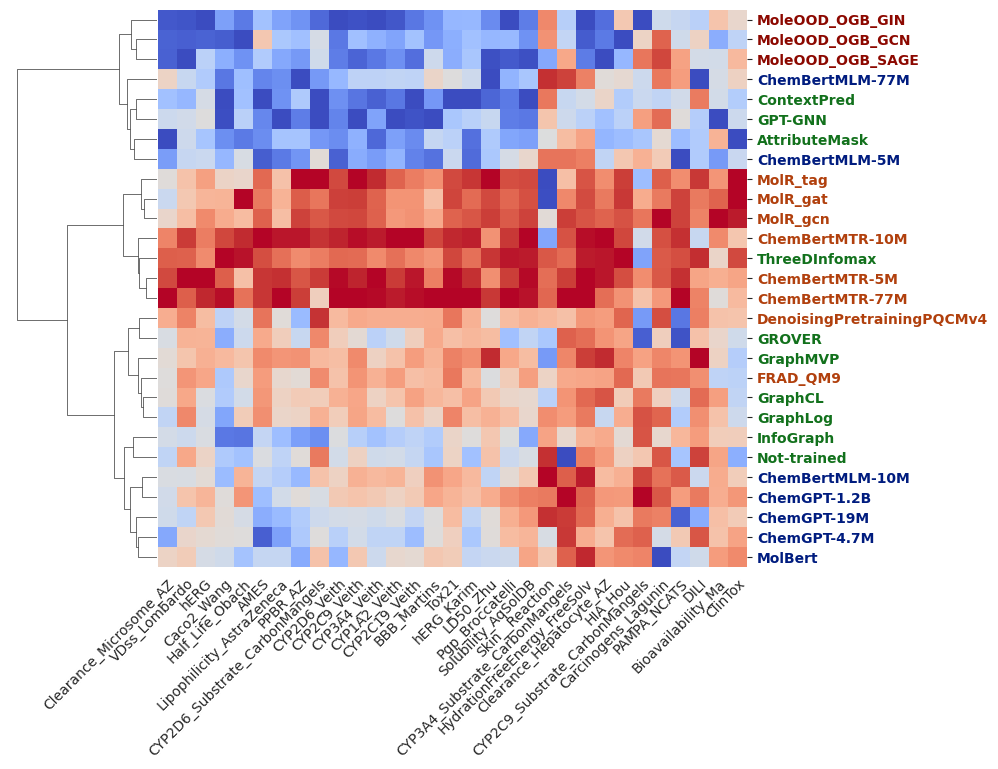

In [58]:
%matplotlib inline

plot_cmap_comm_tasks(df, df_downs, 1, method="ward")
plt.xlabel("")
plt.ylabel("")
plt.savefig(
    f"{LATEX_FIG_PATH}/molecule/communities_task_{method}.pdf",
    format="pdf",
    bbox_inches="tight",
)

In [ ]:
from utils_notebook import *



In [ ]:
%matplotlib inline

plot_com(
    df,
    figsize=7,
    com_resolution=1,
    min_edge_width=0.5,
    max_edge_width=1,
    min_alpha=0,
    max_alpha=0.8,
    clip_min_values_alpha=0.1,
    node_cmap_offset=0,
    edge_cmap_offset=0,
    fontsize=5,
    com_pad_by=100,
    sparsity=0.9,
    node_size=5
)


In [ ]:
plot_com(
    df,
    figsize=7,
    com_resolution=1,
    min_edge_width=0.5,
    max_edge_width=1,
    min_alpha=0,
    max_alpha=0.5,
    clip_min_values_alpha=0.0,
    node_cmap_offset=0,
    edge_cmap_offset=0,
    fontsize=6,
    com_pad_by=1,
    sparsity=0.5,
    node_size=4
)

In [ ]:
plot_com(
    df,
    figsize=7,
    com_resolution=1,
    min_edge_width=0.5,
    max_edge_width=1,
    min_alpha=0,
    max_alpha=0.5,
    clip_min_values_alpha=0.0,
    node_cmap_offset=0,
    edge_cmap_offset=0,
    fontsize=7,
    com_pad_by=1.1,
    sparsity=0.7,
    node_size=6
)